# Redes Neuronales para credit scoring.

In [29]:
import pandas as pd
import numpy as np
import torch


# Carga de datos    
df = pd.read_csv('df_credit_scoring.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   checking_status      1000 non-null   object
 1   duration             1000 non-null   int64 
 2   credit_history       1000 non-null   object
 3   purpose              1000 non-null   object
 4   credit_amount        1000 non-null   int64 
 5   savings              1000 non-null   object
 6   employment           1000 non-null   object
 7   installment_rate     1000 non-null   int64 
 8   personal_status_sex  1000 non-null   object
 9   other_debtors        1000 non-null   object
 10  residence_since      1000 non-null   int64 
 11  property             1000 non-null   object
 12  age                  1000 non-null   int64 
 13  installment_plans    1000 non-null   object
 14  housing              1000 non-null   object
 15  existing_credits     1000 non-null   int64 
 16  job    

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Ejemplo de un pipeline para escalar características
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin

# Crear el wrapper de PyTorchClassifier
class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10, lr=0.001, batch_size=32):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        
    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        
        # Definir el optimizador
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Entrenamiento
        for epoch in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return self
    
    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def predict_proba(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        probabilities = nn.Softmax(dim=1)(outputs)
        return probabilities.numpy()

In [64]:
class ConvNet1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(ConvNet1D, self).__init__()
        
        # Definir las capas convolucionales y de pooling
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Las capas totalmente conectadas (fc) se definirán dinámicamente
        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))

        # Aplanar el tensor antes de las capas totalmente conectadas
        x = x.view(x.size(0), -1)
        
        # Crear la capa fc1 dinámicamente en función del tamaño de la salida
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128)
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [103]:
# Parámetros
input_channels = 1  # Número de canales de entrada (p. ej. 1 si es un vector 1D)
num_classes = 2    # Número de clases a predecir
batch_size = 16     # Tamaño del batch
sequence_length = 20  # Longitud de las secuencias 1D

# Crear una instancia del modelo
model = ConvNet1D(input_channels=input_channels, num_classes=num_classes)

# Definir un optimizador y una función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Ejemplo de entrada (batch de secuencias 1D)
inputs = torch.randn(batch_size, input_channels, sequence_length)
labels = torch.randint(0, num_classes, (batch_size,))

# Paso hacia adelante (forward)
outputs = model(inputs)

# Cálculo de la pérdida
loss = criterion(outputs, labels)

# Paso hacia atrás (backward) y optimización
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Loss:", loss.item())

Loss: 0.6946545839309692


In [68]:
inputs.shape


torch.Size([16, 1, 20])

In [76]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings', 'employment', 'installment_rate',
       'personal_status_sex', 'other_debtors', 'residence_since', 'property',
       'age', 'installment_plans', 'housing', 'existing_credits', 'job',
       'num_dependents', 'telephone', 'foreign_worker', 'class'],
      dtype='object')

In [102]:
(df['class']-1).value_counts(normalize= True)

class
0    0.7
1    0.3
Name: proportion, dtype: float64

In [125]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

# Dividir los datos en entrenamiento y prueba
X_train, X_test_val, y_train, y_test_val = train_test_split(df.drop(columns=['class']),
                                                            df['class']-1,
                                                            test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

# Dividir las columnas numéricas y categóricas
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Definir el preprocesador para las columnas numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputación con la media
    ('scaler', MinMaxScaler())                    # Escalado Min-Max
])

# Definir el preprocesador para las columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputación con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # Codificación One-Hot
])

# Combinar ambos preprocesadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline de preprocesamiento
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Escalar las características de entrenamiento y prueba
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Paso 2: Redimensionar los datos para que sean compatibles con Conv1D (batch_size, 1, sequence_length)
X_train_reshaped = X_train_transformed.reshape(X_train_transformed.shape[0], 1, X_train_transformed.shape[1])
X_test_reshaped = X_test_transformed.reshape(X_test_transformed.shape[0], 1, X_test_transformed.shape[1])


# Definir el pipeline con el clasificador de PyTorch
model = ConvNet1D(input_channels=1, num_classes=2)
pytorch_clf = PyTorchClassifier(model=model, epochs=200)

model_pipeline = Pipeline([
    ('classifier', pytorch_clf)
])

# Entrenar el pipeline
model_pipeline.fit(X_train_reshaped, y_train)

# Hacer predicciones
predictions = model_pipeline.predict(X_test_reshaped)
print(predictions)

[1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1]


In [127]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        72
           1       0.60      0.43      0.50        28

    accuracy                           0.76       100
   macro avg       0.70      0.66      0.67       100
weighted avg       0.74      0.76      0.75       100



In [128]:
probas = model_pipeline.predict_proba(X_test_reshaped)

probas[:, 0]

array([0.48424444, 0.5581329 , 0.6561995 , 0.61704385, 0.61617804,
       0.5868509 , 0.5925594 , 0.43225968, 0.48203754, 0.4711819 ,
       0.6332621 , 0.6805263 , 0.44443253, 0.777389  , 0.6828494 ,
       0.5288065 , 0.8907697 , 0.8507227 , 0.71818304, 0.9434105 ,
       0.69232583, 0.9387541 , 0.6806935 , 0.5137271 , 0.79180825,
       0.9416888 , 0.7038826 , 0.6583898 , 0.4697754 , 0.8938524 ,
       0.7430609 , 0.6567351 , 0.41047695, 0.7006605 , 0.80062336,
       0.8051268 , 0.8771317 , 0.8132226 , 0.5013436 , 0.8903877 ,
       0.6144134 , 0.8438006 , 0.78378487, 0.8800385 , 0.91559696,
       0.9452706 , 0.6522447 , 0.74193686, 0.53039783, 0.77936167,
       0.68516284, 0.34129247, 0.93410337, 0.8780921 , 0.8981212 ,
       0.46875155, 0.70335424, 0.77987015, 0.6619937 , 0.50744843,
       0.95884776, 0.5455804 , 0.92277306, 0.70553356, 0.39754364,
       0.7047104 , 0.69551677, 0.76732916, 0.88883126, 0.8302914 ,
       0.36904934, 0.782319  , 0.66783434, 0.89774054, 0.27765

In [129]:
y_test.value_counts()

class
0    72
1    28
Name: count, dtype: int64

0.6153846153846154
0.3535353535353536


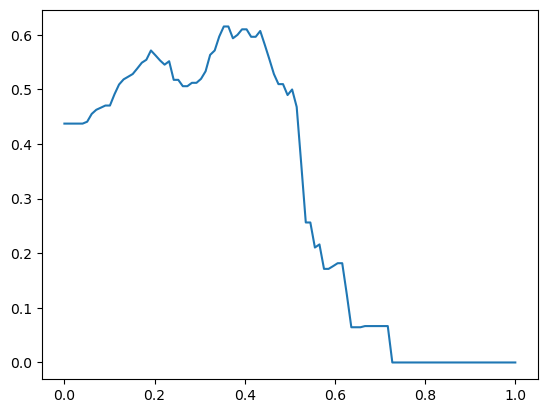

In [130]:
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

thresholds = []
f1s = []

for proba in np.linspace(start=0, stop=1, num=100):
    y_pred_proba = np.where(probas[:, 1]< proba, 0, 1)
    thresholds.append(proba)
    f1s.append(f1_score(y_test, y_pred_proba))

plt.plot(thresholds, f1s)


print(max(f1s))
print(thresholds[np.argmax(f1s)])